<a href="https://colab.research.google.com/github/binaria010/PricingTheory/blob/main/Heston_Stochastic_Vol_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Heston stochastic volatility model </h1>

$$
\begin{align*}
dS(t) &= S(t)(rdt +\sqrt{V(t)}dB(t)),\quad S(0)>0\\
dV(t) &= \kappa(\theta - V(t))dt +\eta\sqrt{V(t)}dW(t),\quad V(0)=\sigma_0^2
\end{align*}
$$

where $B, W$ are two correlated $\mathbb{Q}$ (risk-neutral) brownian motions with correlation $dB(t)dW(t) = \rho dt$.

The variance process $V$ follows a CIR model and the meaning of the parameters is:

*  $\sigma_0^2$: initial variance level
*  $\theta$: long-term variance level (long-term mean of $V(t)$)
*  $\kappa$: mean reversion speed of variance
*  $\eta$: volatility of variance
*  $\rho$: correlation between asset price and its variance


with the constrain that $2\kappa\eta > \theta^2$ in order for $V(t)$ to be positive.

By Ito formula the process $X(t):=\log(S(t))$ follows the SDE:

$$
dX(t) = \left(r - \frac{V(t)}{2}\right)dt +\sqrt{V(t)}dB(T),\quad X(0) = \log(S(0))
$$

The first objective is to find the <em><a href = "https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)" target ="_blank" > characteristic function</a></em> of the random variable $X(t)$ (for $t$ fixed) and then give an expression (semi-analytical) of the price of a European call via the <em><a href= "https://en.wikipedia.org/wiki/Fourier_transform" target="_blank">Fourier transform</a></em>.

<h3>Characteristic function of Heston model</h3>

The characteristic function of the random variable $X(t):=\log(S(t))$ is:

$$
\begin{align*}
\phi_t(u) :=\mathbb{E}[e^{iuX(t)}] &= \exp[(\log S(0) +rt)iu]\\
&\times \exp\left\{\theta\kappa\eta^{-2}\left[(\kappa -i\rho\eta u - d)t -2\log\left(\frac{1- ge^{-dt}}{1 - g}\right) \right]\right\}\\
 &\times \exp\left[\sigma_0^2\eta^{-2}\frac{(\kappa - i\rho\eta u -d)(1-e^{-dt})}{1 -ge^{-dt}}\right]
\end{align*}
$$


with:

$$
d:= \left[(i\rho\eta u - k)^2 +\eta^2(u^2 +iu)\right]^{1/2},\qquad g:=\frac{\kappa - i\rho\eta u - d}{\kappa - i\rho\eta u +d}
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.stats
import time
import scipy.optimize


In [ ]:
def char_function_Heston(u, time_to_mat,params):

    """
    computes the characteristic function of X(t)
    """
    S_0, r, sigma_0, eta, kappa, theta, rho= params.values()
    t = time_to_mat
    d = np.sqrt((1j*rho*eta*u - kappa)**2 +eta**2*(1j*u +u**2))
    g = (kappa - 1j*rho*eta*u - d)/(kappa -1j*rho*eta*u +d)

    term1 = theta*kappa/eta**2 * ((kappa - 1j*rho*eta*u -d)*t - 2*np.log((1-g*np.exp(-d*t))/(1 - g)))
    term2 = sigma_0**2/eta**2 * (kappa -1j*rho*eta*u - d)*(1 - np.exp(-d*t))/(1 - g*np.exp(-d*t))

    phi = np.exp(1j*(np.log(S_0) + r*t)*u + term1 + term2)

    return phi

def integrand(u, k, time_to_mat, params, alpha):
    """
    k: float. log strikes
    """

    r = params['r']
    t = time_to_mat
    integr = np.exp(-1j*u*k -r*t)*char_function_Heston(u - 1j*(alpha +1), t,params)/(alpha**2 +alpha -u**2 +1j*(2*alpha +1)*u)
    return np.real(integr)

def price_call_Heston(K, time_to_mat, params, method = "Quad", alpha = 1.5):

    k = np.log(K)  # log strike

    if method == "Quad":
        integral, error = quad(lambda u: integrand(u, k, time_to_mat, params, alpha), 0, np.inf)
        C_k = np.exp(-alpha*k)/np.pi *integral

    return C_k

def price_Heston(strikes, time_to_mat, params):

    if np.isscalar(strikes):
        return price_call_Heston(strikes, time_to_mat, params)

    prices = []

    for K in strikes:
        prices.append(price_call_Heston(K, time_to_mat, params))

    return np.array(prices)

# Pricing with Fourier


def psi_function(u, time_to_mat, alpha, params):

    T = time_to_mat
    r = params["r"]
    psi = (np.exp(-r*T)*char_function_Heston(u - 1j*(alpha +1),T, params))/(alpha**2 +alpha -u**2 +1j*(2*alpha +1)*u)

    return psi

def price_Fourier(K, time_to_mat, N, h, params,  alpha=1.5):

    """
    computes the price function C(k) of european call as a function the strike K
    using the Fourier transform representation and FFT algorithm

    N : int. size of grid for the k's
    alpha: parameter for the Fourier transform to be defined
    params: parameters of the model
    """

    t = time_to_mat
    lamb = 2*np.pi/(N*h)
    # b = lamb*N/2

    grid = np.arange(0, N)
    u = h*grid

    k = np.zeros(N)
    beta = np.log(K)  #np.log(params["S_0"]) - 0.5*lamb*N
    k  = beta + lamb*grid
    chi = np.exp(-1j*beta*u)*h*psi_function(h*grid, t,alpha, params)
    chi[0] = 0.5*chi[0]
    C_k = 1/np.pi * np.exp(-alpha*k)*np.fft.fft(chi)

    return C_k.real[0]

def price_Fourier_wrapper(strikes, maturities, params, N=2**12, h=0.25):

    if np.isscalar(maturities):
        maturities = [maturities]

    prices = np.zeros((len(strikes), len(maturities)))

    for i,K in enumerate(strikes):
        for j, time_to_mat in enumerate(maturities):
            prices[i, j] = price_Fourier(K, time_to_mat, N, h, params)

    if len(maturities) == 1:
        prices.squeeze(axis = 1)

    return prices




Now, to simulate the Heston model and price with Monte Carlo method:

In [ ]:
def simulate_bm_increment(C,N_sim):

    """
    simulates m= C.shape[0] correlated brownian motions with C the correlation matrix
    """

    A = np.linalg.cholesky(C) # C is the correlation matrix
    Z = np.random.normal(size = (N_sim,C.shape[0]))
    dW = Z @ A.T
    return dW

def Price_Heston_MC_milstein(K, time_to_mat, m, params, N_sim):

    S_0,r,sigma_0, eta, kappa,theta,rho = params.values()
    T = time_to_mat

    S_t = S_0 * np.ones((N_sim))            # stock price
    X_t = np.zeros((N_sim))                 # log of sotck price
    v_t = sigma_0**2 * np.ones((N_sim))     # variance process
    C = np.array([[1,rho],[rho,1]])         # correlation matrix
    h = T/m                                 # step for the Euler simulation
    t = 0
    for _ in range(m):

        dW = simulate_bm_increment(C,N_sim)
        X_t = X_t + (r - 0.5 * v_t) * h + np.sqrt(v_t * h) * dW[:,0]
        v_t = np.maximum(v_t + kappa * (theta - v_t) * h +
                         eta * np.sqrt(v_t * h) * dW[:,1]
                         + 0.25 * (eta ** 2) * h * (dW[:,1] ** 2 - 1),0)

    S_t = S_0 * np.exp(X_t).reshape(-1,1)
    payoff =  np.maximum(S_t - K, 0)
    P_hat = np.exp(-r * T) *np.mean(payoff, axis=0)


    # std = np.sqrt(np.var(P)/N)
    # q = stats.norm.ppf(0.975)
    # CI = [P_hat - q * std, P_hat + q * std]


    return P_hat  #, std, CI, P

def char_function(u,time_to_mat, params):

    """
    computes the characteristic function of X(t)
    """
    S_0, r, sigma_0, eta, kappa, theta, rho= params.values()
    t = time_to_mat
    d = np.sqrt((1j*rho*theta*u - kappa)**2 +theta**2*(1j*u +u**2))

    g = (kappa - 1j*rho*theta*u - d)/(kappa -1j*rho*theta*u +d)
    alpha = eta*kappa/theta**2 * ((kappa - 1j*rho*theta*u -d)*t - 2*np.log((1-g*np.exp(-d*t))/(1 - g)))
    beta = sigma_0**2/theta**2 * (kappa -1j*rho*theta*u - d)*(1 - np.exp(-d*t))/(1 - g*np.exp(-d*t))
    
    phi = np.exp(1j*(np.log(S_0) + r*t)*u +alpha +beta)

    return phi

def Phi_X_T(u, time_to_mat, params):

    """
        computes the characteristic function of X(t)
    """
    S_0, r, sigma_0, eta, kappa, theta, rho= params.values()
    T = time_to_mat
    x = np.log(S_0)
    v0 = sigma_0**2
    gamma = np.sqrt(theta**2*u*(u +1j) +(kappa - 1j*rho*theta*u)**2)
    term1 = -u*(u+1j)*v0/(gamma/np.tanh(0.5*gamma*T) + (kappa -1j*rho*theta*u))#/gamma)
    term2 = kappa*eta*T*(kappa-1j*rho*theta*u)/theta**2
    numerator = np.exp(term1 + term2 +1j*(x + r*T)*u)
    denominator = (np.cosh(0.5*gamma*T) + (kappa -1j*rho*theta*u)/gamma *np.sinh(0.5*gamma*T))**(2*kappa*eta/theta**2)

    phi = numerator/denominator

    return phi








In [ ]:
T = 1
S_0 =100.0
K = 80.0
r = 0.05
q = 0.01
kappa =2.0
theta = 0.3
eta = 0.05
sigma_0 = 0.2
rho = -0.7

# Fourier params
N = 2**10
h=0.25

# Monte Carlo params
N_sim = 10**5
m = 100
params = {"S_0": S_0, "r": r, "sigma_0": sigma_0,
          "eta": eta, "kappa":kappa, "theta": theta, "rho":rho}
strikes = np.linspace(80.0, 120.0, 40)

pricesfourier = price_Fourier_wrapper(strikes, T,params, N, h)
prices_MC = Price_Heston_MC_milstein(strikes, T, m,params,N_sim)
prices_integr = price_Heston(strikes, T, params)



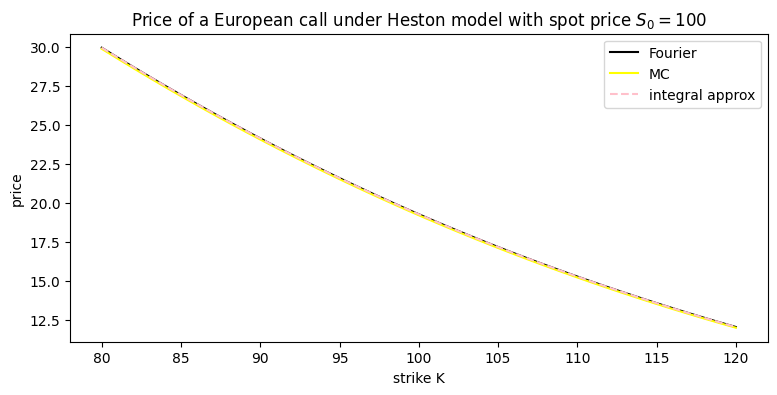

In [ ]:
plt.figure(figsize=(9,4))
plt.plot(strikes, pricesfourier, label='Fourier', color = 'black')
plt.plot(strikes, prices_MC, label = 'MC', color = 'yellow')
plt.plot(strikes, prices_integr, label = 'integral approx', color = 'pink', linestyle = 'dashed')
plt.xlabel('strike K')
plt.ylabel('price')
plt.legend()
plt.title("Price of a European call under Heston model with spot price $S_0=100$")
plt.show()

Example 2

In [ ]:
r = 0.05 # interest rate
S_0 = 100.0 # initial price
T = 1 # maturity (in years)
theta = 0.04 # long term volatility
kappa = 1 # mean reversion speed of volatility
eta = 0.3 # vol of vol (instantaneous volatility of the volatility)
sigma_0 = 0.2 # initial volatility v_0 = sigma_0^2
rho = 0.5 # correlation coefficient
h = 0.25
K = 100.0

params = {"S_0": S_0, "r": r, "sigma_0": sigma_0,
          "eta": eta, "kappa":kappa, "theta": theta, "rho":rho}

# parameters for MC
m = 100
N_sim = 10**5


# parameters for the FFT method:
N = 2**12
h =0.25



In [ ]:
strikes = np.linspace(80, 120, 40)

# montecarlo estiamtion
start_MC = time.time()
prices_MC = Price_Heston_MC_milstein(strikes, T, m, params, N_sim)
end_MC = time.time()

print(f"time: {end_MC - start_MC}s")

time: 0.8207929134368896s


In [ ]:

# integral approximation
start = time.time()
prices_integral = price_Heston(strikes, T, params)
end = time.time()

print(f"time: {end - start}s")

time: 0.08092284202575684s


In [ ]:
# Fourier method

start = time.time()
pricesfourier = price_Fourier_wrapper(strikes, T, params, N, h)
end = time.time()

print(f"time: {end - start}s")

time: 0.04053092002868652s


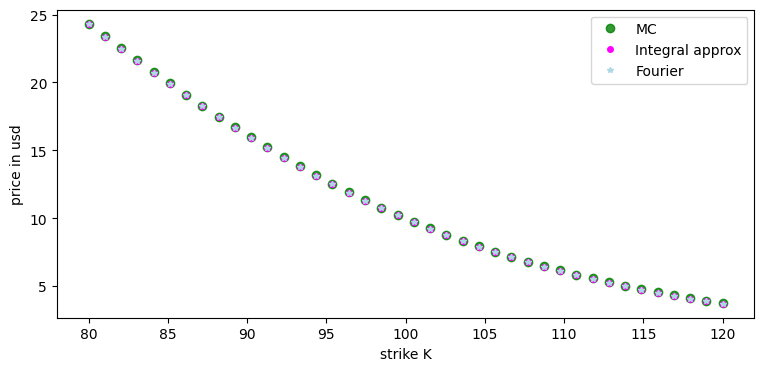

In [ ]:
plt.figure(figsize=(9,4))
plt.plot(strikes, prices_MC, ".", markersize = 12, alpha =0.8, label = 'MC', color = "green")
plt.plot(strikes, prices_integral, "o", markersize = 4, label = "Integral approx", color = "magenta")
plt.plot(strikes, pricesfourier, "*", markersize = 4, label = "Fourier", color = "lightblue")
plt.xlabel("strike K")
plt.ylabel("price in usd")
plt.legend()
plt.show()

<h2> Implied Volatility </h2>

In [ ]:

# Black-Scholes formula for a European call option
def black_scholes_call(S, K, time_to_mat, r, sigma):

    T = time_to_mat
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * scipy.stats.norm.cdf(d1) - K * np.exp(-r * T) * scipy.stats.norm.cdf(d2)
    return call_price

# Function to calculate implied volatility using the Newton-Raphson method

def implied_volatility_per_strike(K, time_to_mat, S_0, r, model_price, method):

    T = time_to_mat
    sigma = 0.2 #np.sqrt(2*np.pi /T)*model_prices[i]/S_0  # initial guess

    if method == 'Newton':
        tol= 1e-8
        max_iterations=100
        for _ in range(max_iterations):
            priceBS = black_scholes_call(S_0, K, T, r, sigma)
            vega = S_0 * np.sqrt(T) * scipy.stats.norm.pdf((np.log(S_0 / K) +
                            (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
            price_diff = priceBS - model_price
            if np.abs(price_diff) < tol :
                break
            sigma -= price_diff / vega

        return sigma

    if method == 'optimizer':
        def objective_function(sigma):
            return (black_scholes_call(S_0, K, time_to_mat, r, sigma) -
                    model_price)**2

        res = scipy.optimize.minimize(objective_function, x0 = 0.2,
                                bounds = [(1e-5, None)], method = 'L-BFGS-B')
        return res.x[0]


def implied_volatility(strikes, time_to_mat, S_0, r, model_prices,
                       method="optimizer"):

    implied_vol = np.zeros(len(strikes))
    for i,K in enumerate(strikes):

        if method == "Newton":
            implied_vol[i] = implied_volatility_per_strike(K, time_to_mat, S_0,
                                    r, model_prices[i], method = method)

        if method == "optimizer":
            implied_vol[i] = implied_volatility_per_strike(K, time_to_mat, S_0,
                                    r, model_prices[i], method = method)

    return implied_vol


Let us compute the implied volatility for several cases:

1. $eta \approx 0$, meaning constant volatility in whose case we should observe a horizontal (approximately) line.

2. Consider several values of $\kappa$ making slow and fast mean reversion.

In [ ]:
r = 0.05 # interest rate
S_0 = 100.0 # initial price
T = 1 # maturity (in years)
theta = 0.04 # long term volatility
kappa = 2 # mean reversion speed of volatility
eta = 0.3 # vol of vol (instantaneous volatility of the volatility)
sigma_0 = 0.2 # initial volatility v_0 = sigma_0^2
rho = -0.5 # correlation coefficient

N = 2**12
h = 0.25

strikes = np.linspace(80, 120, 40)

params = {"S_0": S_0, "r": r, "sigma_0": sigma_0,
          "eta": eta, "kappa":kappa, "theta": theta, "rho":rho}



In [ ]:

params1 = params.copy()
params1['eta'] = 0.01
params1['theta'] = sigma_0**2


prices_Quad = price_Heston(strikes, time_to_mat=T, params=params1)
prices_Fou = price_Fourier_wrapper(strikes, T, params=params1, N= N, h = h)
implied_vol = implied_volatility(strikes, T, S_0, r, prices_Quad, method = 'optimizer')
implied_vol_Fou = implied_volatility(strikes, T, S_0, r, prices_Fou, method='optimizer')

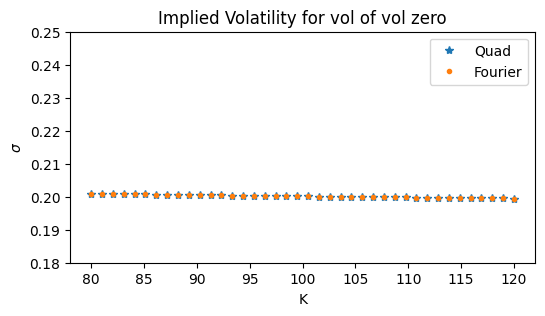

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(strikes, implied_vol, '*', label = 'Quad')
plt.plot(strikes, implied_vol_Fou, '.', label = 'Fourier')
plt.xlabel("K")
plt.ylabel("$\\sigma$")
plt.ylim((0.18, 0.25))
plt.title("Implied Volatility for vol of vol zero")
plt.legend()
plt.show()

Implied volatility for different values of $\kappa$:

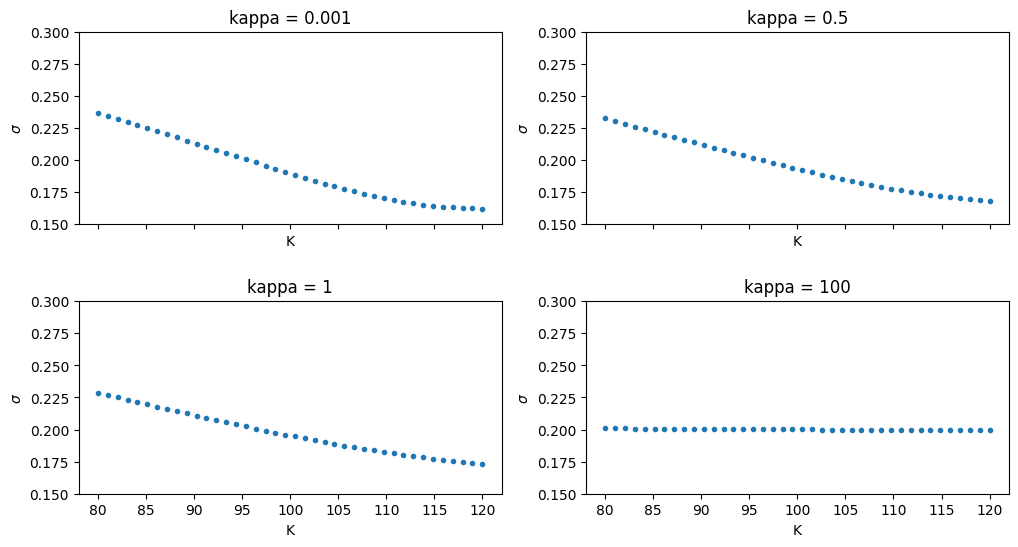

In [ ]:
kappas = [0.001, 0.5, 1, 100]
plt.subplots(2,2, figsize=(12,6), sharex=True)
for i, kappa in enumerate(kappas):

    params2 = params.copy()
    params2['kappa'] = kappa

    # price = price_Heston(Ks, time_to_mat=T, params=params2)
    prices = price_Fourier_wrapper(strikes, T, params=params2, N=N, h=h)
    implied_vol = implied_volatility(strikes,T, S_0,r, prices)

    plt.subplot(2,2,i+1)
    plt.plot(strikes, implied_vol, '.')
    plt.xlabel("K")
    plt.ylabel("$\\sigma$")
    plt.ylim((0.15, 0.3))
    plt.title("kappa = " + str(kappa))
plt.subplots_adjust(top=0.88, hspace=0.4)
plt.show()


<h2> Calibration of parameters </h2>

In [ ]:
def dHeston(K, time_to_mat,delta, params):

    """
    This function computes the derivatives of the function for the call price under the Heston model w.r.t its four
    parameters kappa, theta, eta, rho. They are computed by finite differences with delta being the step.

    Inputs

    K: float. The strike
    delta: float. The step for the finite differences
    params: dict. A dictionary with all the parameters: S_0, T, r, kappa, eta, theta, rho
    """
    k = np.log(K)
    der_Heston = {'kappa':0, 'eta':0, 'theta':0, 'rho':0}
    price = price_Heston(k, params)

    for var in der_Heston.keys():
        params1 = params.copy()
        params1[var] += delta
        der_Heston[var] = (price_Heston(k, time_to_mat,params1) -price)/delta

    return der_Heston

def price_Heston_wrapper(K, time_to_mat,params):

    def ret_price(kappa,theta,eta,rho):
        params_prime = params.copy()
        params_prime.update({'kappa': kappa, 'theta': theta, 'eta':eta, 'rho':rho})
        return price_Heston(K, time_to_mat, params_prime)

    return ret_price

def price_Fourier_function(strikes, maturities, params, N = 2**12, h=0.25):

        def ret_price_fou(kappa, theta, eta, rho):
            params_prime = params.copy()
            params_prime.update({'kappa': kappa, 'theta': theta, 'eta':eta, 'rho':rho})
            return price_Fourier_wrapper(strikes,maturities, params_prime, N, h)

        return ret_price_fou

def relative_error_function(vars, K, time_to_mat, params, market_prices):

    kappa, theta, eta, rho = vars
    # error = 0.5*np.sum(((price_Heston_wrapper(K, time_to_mat, params)(kappa, theta, eta, rho) - market_prices)/market_prices)**2)
    error = 0.5*np.sum(((price_Fourier_function(K, time_to_mat, params)(kappa, theta, eta, rho) - market_prices)/market_prices)**2)

    return error


def constraint_kappa(vars):
    kappa, _ , _ , _ = vars
    return kappa

def constraint_theta(vars):
    _ , theta , _ , _ = vars
    return theta

def constraint_eta(vars):
    _ , _ , eta , _ = vars
    return eta

def constraints():

    return [{'type': 'ineq', 'fun': constraint_kappa},
            {'type': 'ineq', 'fun': constraint_theta},
            {'type': 'ineq', 'fun': constraint_eta}]


In [ ]:

def calibration(objective, initial_guess, args, bounds, method, print_error = True):

    vars = ['kappa', 'theta', 'eta', 'rho']

    res = scipy.optimize.minimize(objective, initial_guess, args=args, bounds=bounds, method = method)

    vals = np.round(res.x, 2)

    if print_error:
        strikes, maturities, params, market_prices,_, _ = args
        error = objective(vals, strikes, maturities, params, market_prices)
        print(f"The value of the objective is : {error}")

    return dict([(var, val) for var, val in zip(vars, vals)])


In [ ]:
# true model:

r = 0.05 # interest rate
S_0 = 100.0 # initial price
T = 1 # maturity (in years)
theta = 0.04 # long term volatility
kappa = 2 # mean reversion speed of volatility
eta = 0.3 # vol of vol (instantaneous volatility of the volatility)
sigma_0 = 0.2 # initial volatility v_0 = sigma_0^2
rho = 0.3 # correlation coefficient

# parameters for the FFT method
N = 2**12
h =0.25

strikes = np.linspace(85, 110, 50)

params = {"S_0": S_0, "r": r, "sigma_0": sigma_0,
          "eta": eta, "kappa":kappa, "theta": theta, "rho":rho}


# model_prices = price_Heston(strikes, time_to_mat=T,params=params)
model_prices_Fou = price_Fourier_wrapper(strikes, T,params=params, N=N, h=h)
market_prices = model_prices_Fou + 0.01*np.random.normal(size = len(model_prices_Fou))

# test for error function
true_vals = [kappa, theta, eta, rho]
relative_error_function(true_vals, strikes, time_to_mat=T,params=params, market_prices=market_prices)


np.float64(0.0007217908999837227)

In [ ]:
bounds = [(1e-5, None), (1e-5, None), (1e-5,None), (-1,1)]


initial_guess =  np.array(true_vals) + np.random.uniform(low = 0.001, high = 0.3, size=len(true_vals))
estimated_params = calibration(relative_error_function, initial_guess, (strikes, T, params, market_prices), bounds, method = None)

In [ ]:
print(f"for initial guess = {initial_guess} the estimated_params are \n {estimated_params}")
print(f"while true parameters are: {[kappa, theta, eta, rho]}")

for initial guess = [2.04073422 0.1983231  0.55442908 0.35240111] the estimated_params are 
 {'kappa': np.float64(6.77), 'theta': np.float64(0.12), 'eta': np.float64(6.5), 'rho': np.float64(-0.0)}
while true parameters are: [2, 0.04, 0.3, 0.3]


Let us compare the prices with the true parameters vs the estimated ones:

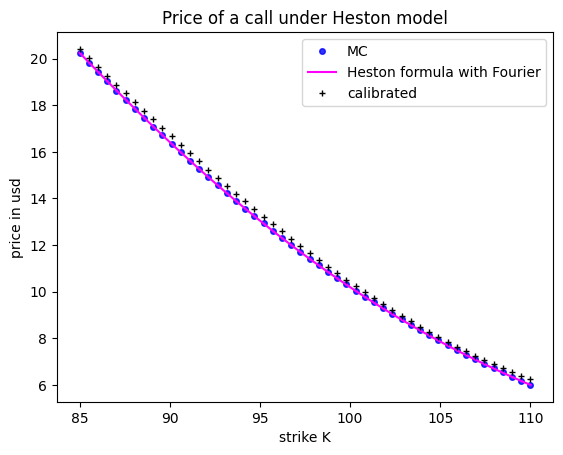

In [ ]:
est_params_prices = params.copy()
est_params_prices.update(estimated_params)

prices_MC = Price_Heston_MC_milstein(strikes, T, m, params, N_sim)
# true_prices_Heston = price_Heston(strikes, T, params)
# est_prices_Heston = price_Heston(strikes, T, est_params_prices)
true_prices_Fou = price_Fourier_wrapper(strikes, T, params, N, h)
est_prices_Fou = price_Fourier_wrapper(strikes, T, est_params_prices, N, h)


plt.plot(strikes, prices_MC, ".", markersize = 8, alpha =0.8, label = 'MC', color = "blue")
plt.plot(strikes, true_prices_Fou, "-", markersize = 4, label = "Heston formula with Fourier", color = "magenta")
plt.plot(strikes, est_prices_Fou, "+", markersize = 4, label = "calibrated", color = "black")
plt.xlabel("strike K")
plt.ylabel("price in usd")
plt.legend()
plt.title('Price of a call under Heston model')
plt.show()

In [ ]:
error_estimation = relative_error_function(true_vals, strikes,T, params,market_prices)
error_estimation

np.float64(0.0007217908999837227)

<h2> Calibration of parameters in volatility world </h2>

In [ ]:
# Black-Scholes formula for a European call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * scipy.stats.norm.cdf(d1) - K * np.exp(-r * T) * scipy.stats.norm.cdf(d2)
    return call_price


def implied_volatility_wrapper(vars, strikes, time_to_mat,params):

    kappa, theta, eta, rho = vars
    params1 = params.copy()
    params1.update({'kappa':kappa, 'theta': theta, 'eta': eta, 'rho':rho})
    # model_prices = price_Heston(strikes, time_to_mat, params1)
    model_prices_Fou = price_Fourier_wrapper(strikes, time_to_mat, params1)

    return implied_volatility(strikes, time_to_mat, params['S_0'], params['r'], model_prices_Fou)

def volatility_error_function(vars, strikes, time_to_mat, params, market_vols):

    # kappa, theta, eta, rho = vars
    implied_vol = implied_volatility_wrapper(vars, strikes, time_to_mat, params)
    error = 0.5*np.sum((implied_vol - market_vols)**2)

    return error



In [ ]:
# true model:

r = 0.05 # interest rate
S_0 = 100.0 # initial price
T = 1 # maturity (in years)
theta = 0.04 # long term volatility
kappa = 2 # mean reversion speed of volatility
eta = 0.3 # vol of vol (instantaneous volatility of the volatility)
sigma_0 = 0.2 # initial volatility v_0 = sigma_0^2
rho = 0.2 # correlation coefficient

strikes = np.linspace(85, 120, 50)

params = {"S_0": S_0, "r": r, "sigma_0": sigma_0,
          "eta": eta, "kappa":kappa, "theta": theta, "rho":rho}


# model_prices = price_Heston(strikes, T,params)
model_prices_Fou = price_Fourier_wrapper(strikes, T,params=params, N=N, h=h)
market_prices = model_prices_Fou + 0.11*np.random.normal(size =model_prices_Fou.shape)



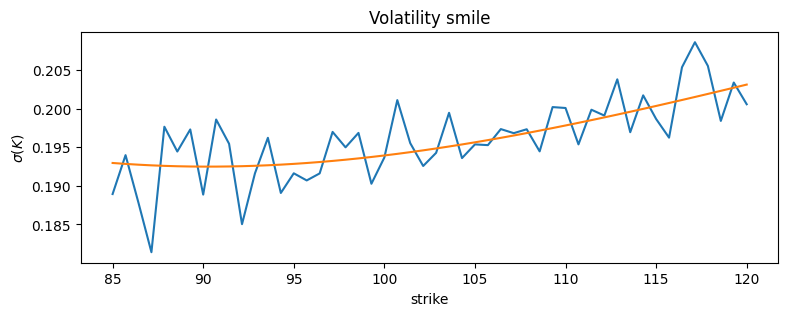

In [ ]:


# testing implied_volatility

market_vols = implied_volatility(strikes, T, S_0, r, market_prices)
implied_vols = implied_volatility(strikes, T,  S_0, r, model_prices_Fou)
plt.figure(figsize=(9,3))
plt.plot(strikes, market_vols, markersize = 4, label = "implied market volatilities")
plt.plot(strikes, implied_vols, markersize = 4, label = "implied model volatilities")
plt.xlabel('strike')
plt.ylabel('$\\sigma(K)$')
plt.title('Volatility smile')
plt.show()


In [ ]:
# testing error function:
vars = [kappa, theta, eta, rho]

volatility_error_function(vars, strikes, T,params, market_vols)

np.float64(0.0003394795088995383)

Now, let us calibrate the model, i.e, find the estimated parameters $\kappa, \theta, \eta, rho$ that minimize the error function:

$$
E(\kappa, \theta, \eta, rho) = \sum_{K \in \text{strikes}}(\sigma_{BS}(K) - \sigma_{market}(K; \kappa, \theta, \eta, rho))**2
$$

In [ ]:
bounds = [(0, None), (0, None), (0,None), (-1,1)]
initial_guess = [0.1, 0.01, 0.1,0.1]


estimated_params_vol = calibration(volatility_error_function, initial_guess, (strikes, T,params, market_vols), bounds, method = None)
estimated_params_prices = calibration(relative_error_function, initial_guess, (strikes, T,params, market_prices), bounds, method = None)


print(f"true parameters are: {[kappa, theta, eta, rho]}")
print(f"initial guess = {initial_guess} ")

print(f"the estimated_params from volatilities are \n {estimated_params_vol}")
print(f"the estimated_params from prices are \n {estimated_params_prices}")



true parameters are: [2, 0.04, 0.3, 0.2]
initial guess = [0.1, 0.01, 0.1, 0.1] 
the estimated_params from volatilities are 
 {'kappa': np.float64(0.04), 'theta': np.float64(0.01), 'eta': np.float64(0.12), 'rho': np.float64(0.27)}
the estimated_params from prices are 
 {'kappa': np.float64(0.0), 'theta': np.float64(0.75), 'eta': np.float64(0.15), 'rho': np.float64(0.21)}


Now, using the estimated parameters compute the Heston prices:

In [ ]:
est_params = params.copy()
est_params.update(estimated_params_vol)
est_params_from_prices = params.copy()
est_params_from_prices.update(estimated_params_prices)


prices_MC = Price_Heston_MC_milstein(strikes, T,m, params, N_sim)
true_prices_Fou = price_Fourier_wrapper(strikes, T,params)
est_prices_Fou_from_vol = price_Fourier_wrapper(strikes, T,est_params)
est_prices_Fou_from_prices = price_Fourier_wrapper(strikes, T,est_params_from_prices)



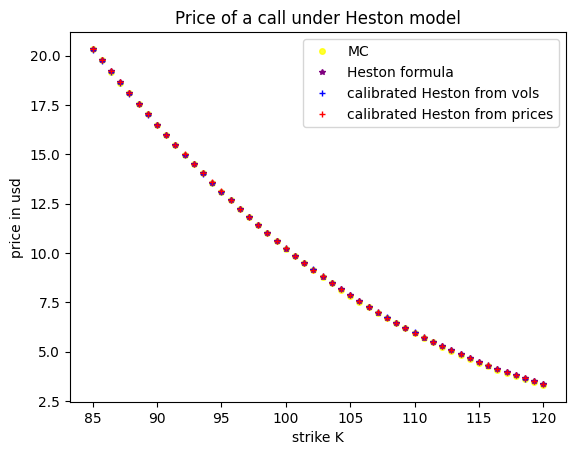

In [ ]:


plt.plot(strikes, prices_MC, ".", markersize = 8, alpha =0.8, label = 'MC', color = "yellow")
plt.plot(strikes, true_prices_Fou, "*", markersize = 4, label = "Heston formula", color = "purple")
plt.plot(strikes, est_prices_Fou_from_vol, "+", markersize = 4, label = "calibrated Heston from vols", color = "blue")
plt.plot(strikes, est_prices_Fou_from_prices, "+", markersize = 4, label = "calibrated Heston from prices", color = "red")
plt.xlabel("strike K")
plt.ylabel("price in usd")
plt.legend()
plt.title('Price of a call under Heston model')
plt.show()

<h2> Calibration from volatility surface </h2>

In [ ]:
def implied_vol_Surf(strikes, maturities, S_0, r, model_prices, solver_method = 'optimizer'):

    """

    model_prices: ndarray of len(strikes) rows and len(maturities) cols
    """

    implied_vol = np.zeros((len(strikes), len(maturities)))



    for i, K in enumerate(strikes):

        for j, T in enumerate(maturities):

            sigma = 0.2 #np.random.uniform(low=0.1, high=0.8)  # initial guess

            if solver_method == 'Newton':
                max_iterations = 100
                tol = 1e-8
                for _ in range(max_iterations):
                    K = strikes[i]
                    T = maturities[j]
                    priceBS = black_scholes_call(S_0, K, T, r, sigma)
                    vega = S_0 * np.sqrt(T) * scipy.stats.norm.pdf((np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
                    price_diff = priceBS - model_prices[i, j]
                    if np.abs(price_diff) < tol :
                        break

                    sigma -= price_diff / vega
            if solver_method == 'optimizer':

                def objective_function(sigma):
                    return (black_scholes_call(S_0, K, T, r, sigma) -model_prices[i,j])**2

                res = scipy.optimize.minimize(objective_function, x0 = 0.2,
                                bounds = [(1e-5, None)], method = 'SLSQP')
                sigma = res.x[0]


            implied_vol[i, j] = sigma

    return implied_vol

def implied_volSurf_wrapper(vars, strikes, maturities,params, pricing_method = 'Fourier', solver_method = "optimizer"):

    kappa, theta, eta, rho = vars
    params1 = params.copy()
    params1.update({'kappa':kappa, 'theta': theta, 'eta': eta, 'rho':rho})
    model_prices = -np.ones((len(strikes), len(maturities)))

    if pricing_method == "Fourier":
        model_prices = price_Fourier_wrapper(strikes, maturities, params1)

    if pricing_method == "Quad":
        for j,T in enumerate(maturities):
            model_prices[:, j] = price_Heston(strikes, T, params1)

    return implied_vol_Surf(strikes, maturities, params['S_0'], params['r'], model_prices, solver_method)



def volatilitySurf_error_function(vars, strikes, maturities, params, market_vols_surf, pricing_method = 'Fourier', solver_method ='optimizer'):

    # kappa, theta, eta, rho = vars
    implied_vol_surface = implied_volSurf_wrapper(vars, strikes, maturities,params, pricing_method, solver_method)
    error = 0.5*np.mean((implied_vol_surface - market_vols_surf)**2)

    return error


In [ ]:

r = 0.05 # interest rate
S_0 = 100.0 # initial price
theta = 0.04 # long term volatility
kappa = 2 # mean reversion speed of volatility
eta = 0.3 # vol of vol (instantaneous volatility of the volatility)
sigma_0 = 0.2 # initial volatility v_0 = sigma_0^2
rho = 0.2 # correlation coefficient

params = {"S_0": S_0, "r": r, "sigma_0": sigma_0,
          "eta": eta, "kappa":kappa, "theta": theta, "rho":rho}

strikes = np.linspace(85, 120, 50)
maturities = np.linspace(0.2, 1.5, 28) # in years
# model_prices_Fou = np.ones((len(strikes), len(maturities)))

model_prices_Fou = price_Fourier_wrapper(strikes, maturities,params=params, N=N, h=h)


start = time.time()
imp_vol_surf = implied_vol_Surf(strikes, maturities, S_0, r, model_prices_Fou, solver_method="optimizer")
market_vols_surf = imp_vol_surf + 0.001 * np.random.normal(loc = 0, scale = 1, size = imp_vol_surf.shape)
# np.maximum(imp_vol_surf + 0.01**np.random.normal(size = imp_vol_surf.shape), 0.000001)
end = time.time()

print(f"Elapsed time {end- start}s")


Elapsed time 1.412964105606079s


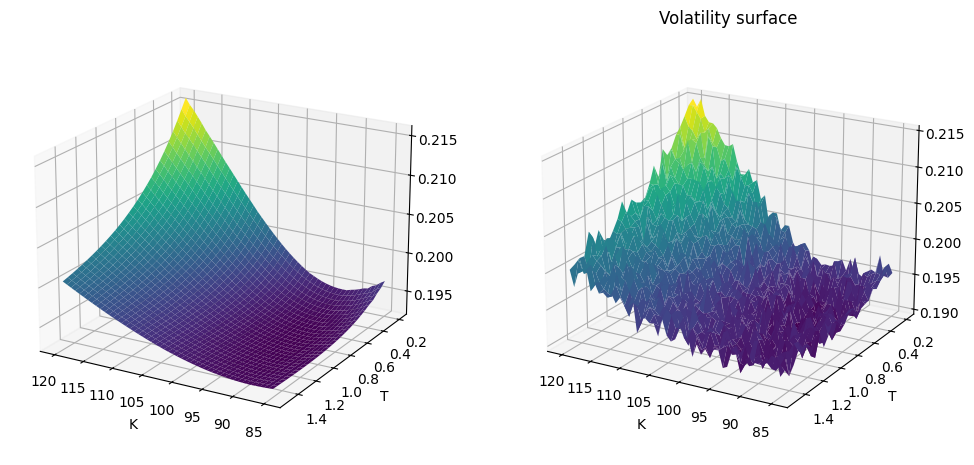

In [ ]:
T, K = np.meshgrid(maturities, strikes)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection = '3d')
ax.plot_surface(K, T,  imp_vol_surf, cmap='viridis')
ax.set_xlabel('K')
ax.set_ylabel('T')
ax.view_init(elev=20, azim=120)
ax1 = fig.add_subplot(122, projection = '3d')
ax1.plot_surface(K, T,  market_vols_surf, cmap='viridis')
ax1.set_xlabel('K')
ax1.set_ylabel('T')
ax1.view_init(elev=20, azim=120)

plt.title('Volatility surface')
plt.show()


Calibration:

In [ ]:
bounds = [(1e-5, None), (1e-5, None), (1e-5,None), (-1,1)]
initial_guess =  [np.abs(np.random.randn()), np.random.uniform(), np.random.uniform(), np.random.uniform(low=-1, high=1)]


true parameters are: [2, 0.04, 0.3, 0.2]
initial guess = [np.float64(0.6721803731446641), 0.4364730591325986, 0.8794520366835722, -0.7571760808659156] 
the estimated_params from volatilities using Fourier as pricing_method are 
 {'kappa': np.float64(0.64), 'theta': np.float64(0.04), 'eta': np.float64(0.24), 'rho': np.float64(0.19)}


In [ ]:


estimated_params_volsurf_Fou = calibration(volatilitySurf_error_function, initial_guess, (strikes, maturities,params, market_vols_surf, 'Fourier', 'optimizer'), bounds, method = None)
# estimated_params_volsurf_quad = calibration(volatilitySurf_error_function, initial_guess, (strikes, maturities,params, market_vols_surf, 'Quad'), bounds, method = None)
print(f"true parameters are: {[kappa, theta, eta, rho]}")
print(f"initial guess = {initial_guess} ")
print(f"the estimated_params from volatilities using Fourier as pricing_method are \n {estimated_params_volsurf_Fou}")
# print(f"the estimated_params from volatilities using Quad as pricing_method are \n {estimated_params_volsurf_quad}")




The value of the objective is : 2.050478862389168e-06
true parameters are: [2, 0.04, 0.3, 0.2]
initial guess = [np.float64(0.6721803731446641), 0.4364730591325986, 0.8794520366835722, -0.7571760808659156] 
the estimated_params from volatilities using Fourier as pricing_method are 
 {'kappa': np.float64(0.64), 'theta': np.float64(0.04), 'eta': np.float64(0.24), 'rho': np.float64(0.19)}


In [ ]:
est_params = params.copy()
est_params.update(estimated_params_volsurf_Fou)

est_prices = price_Fourier_wrapper(strikes, maturities, est_params)
est_vols = implied_vol_Surf(strikes, maturities, S_0, r, est_prices)




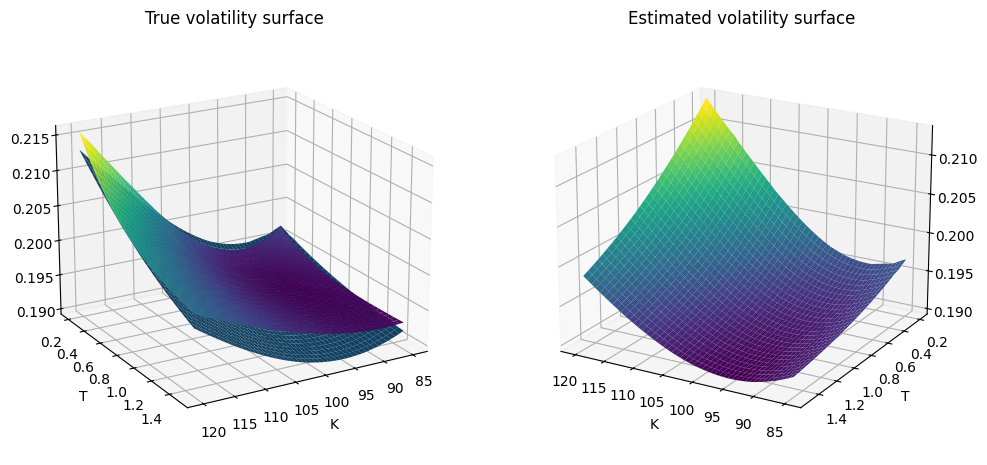

In [ ]:
T, K = np.meshgrid(maturities, strikes)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection = '3d')
ax.plot_surface(K, T,  imp_vol_surf, cmap='viridis')
ax.plot_surface(K, T,  est_vols)
ax.set_xlabel('K')
ax.set_ylabel('T')
ax.view_init(elev=20, azim=60)
ax.set_title('True volatility surface')

ax1 = fig.add_subplot(122, projection = '3d')
ax1.plot_surface(K, T,  est_vols, cmap='viridis')
ax1.set_xlabel('K')
ax1.set_ylabel('T')
ax1.view_init(elev=20, azim=120)
ax1.set_title("Estimated volatility surface")

plt.show()

<h3> Finding optimal initialization </h3>

In [ ]:
def optimal_initialization(Theta1, Theta2, objective, *args):

    """
    Theta1 = [kappa1, theta1, eta1, rho1]
    Theta2 = [kappa2, theta2, eta2, rho2]
    """

    a = np.linspace(0., 1, 20)
    Theta = np.outer(a, np.array(Theta1)) + np.outer((1-a), np.array(Theta2))
    cost_function = -np.ones(len(a))
    strikes, maturities, params, market_prices = args

    for i in range(Theta.shape[0]):
        cost_function[i] = objective(
                        Theta[i, :],strikes, maturities, params, market_prices)


    a_star = np.argmin(cost_function)
    Theta_star = Theta[a_star]

    plt.figure(figsize=(10,4))
    plt.plot(a, cost_function, "*")
    plt.vlines(a[a_star], ymin = 0, ymax= np.max(cost_function),linestyle = '--', color = 'red')
    plt.xlabel("$\\alpha$")
    plt.ylabel('Cost function')
    plt.title('Cost as a function of the $\\alpha$ parameter')
    plt.show()

    return Theta_star, cost_function


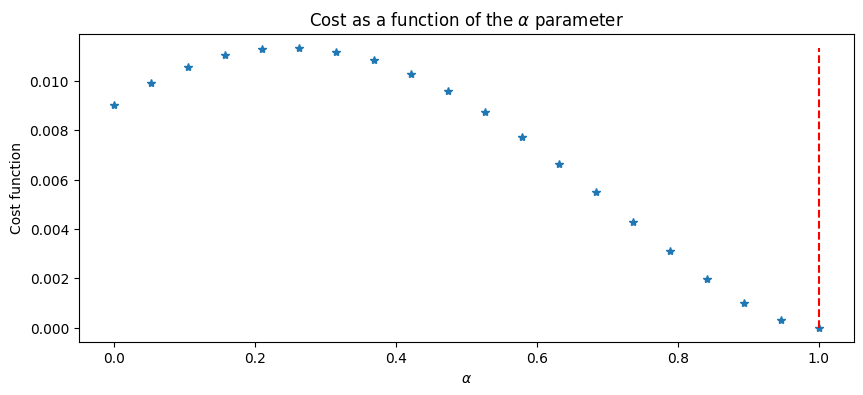

array([2.  , 0.04, 0.3 , 0.2 ])

In [ ]:
Theta1 = [kappa, theta, eta, rho]  # these are the true parameters
Theta2 = initial_guess
optimal_initialization(Theta1, Theta2, volatilitySurf_error_function, strikes, maturities, params, market_vols_surf)

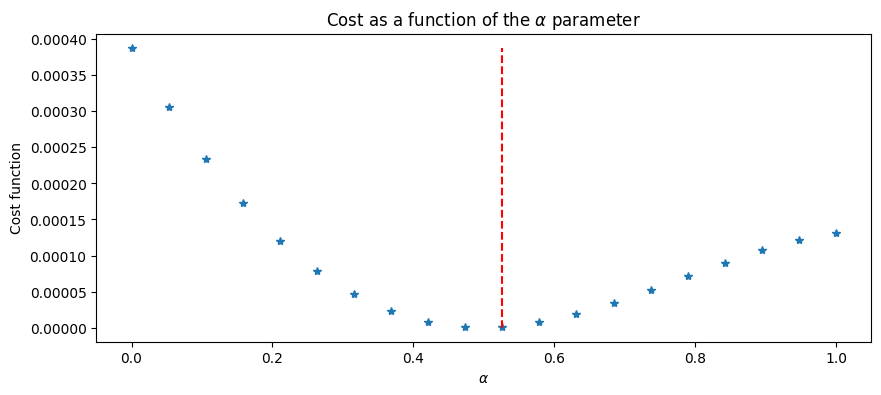

[1.94736842 0.03894737 0.29210526 0.19473684]


In [ ]:
Theta2 = [1.5*kappa, 1.5*theta, 1.5*eta, 1.5*rho]   # these are the true parameters
Theta1 = [0.5*kappa, 0.5*theta, 0.5*eta, 0.5*rho]
opt, cost = optimal_initialization(Theta1, Theta2, volatilitySurf_error_function, strikes, maturities, params, market_vols_surf)

print(opt)

Example 2

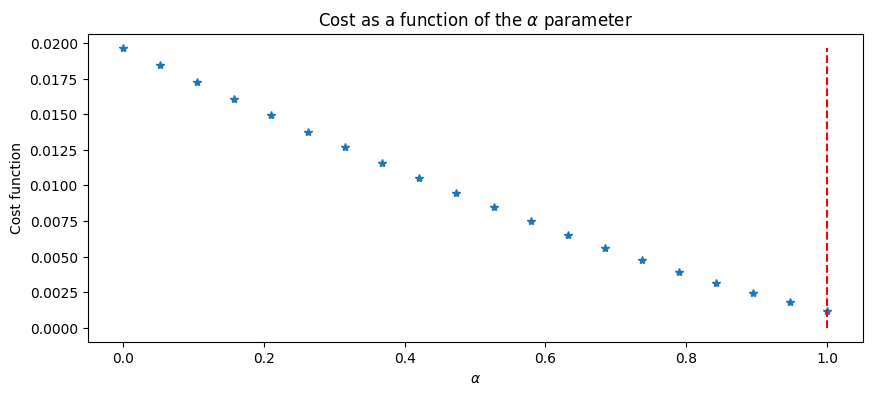

In [ ]:
# np.random.seed(35380450)

Theta12 = [np.abs(np.random.randn()), np.random.uniform(), np.random.uniform(), np.random.uniform(low=-1, high=1)]
Theta22 = [np.abs(np.random.randn()), np.random.uniform(), np.random.uniform(), np.random.uniform(low=-1, high=1)]

optimal_initial_guess, cost = optimal_initialization(Theta12, Theta22,
                            volatilitySurf_error_function, strikes, maturities, params, market_vols_surf)



In [ ]:
optimal_initial_guess

array([ 0.33427128,  0.23142714,  0.42416488, -0.06869079])

In [ ]:
estimated_params_volsurf_Fou = calibration(volatilitySurf_error_function, optimal_initial_guess,
                                           (strikes, maturities,params, market_vols_surf, 'Fourier', 'optimizer'),
                                         bounds, method = None)

print(f"true parameters are: {[kappa, theta, eta, rho]}")
print(f"initial guess = {optimal_initial_guess} ")

print(f"the estimated_params from volatilities using Fourier as pricing_method are \n {estimated_params_volsurf_Fou}")



The value of the objective is : 1.5469662052485899e-06
true parameters are: [2, 0.04, 0.3, 0.2]
initial guess = [ 0.33427128  0.23142714  0.42416488 -0.06869079] 
the estimated_params from volatilities using Fourier as pricing_method are 
 {'kappa': np.float64(0.28), 'theta': np.float64(0.04), 'eta': np.float64(0.19), 'rho': np.float64(0.21)}


In [ ]:
est_params = params.copy()
est_params.update(estimated_params_volsurf_Fou)

est_prices = price_Fourier_wrapper(strikes, maturities, est_params)
est_vols = implied_vol_Surf(strikes, maturities, S_0, r, est_prices)




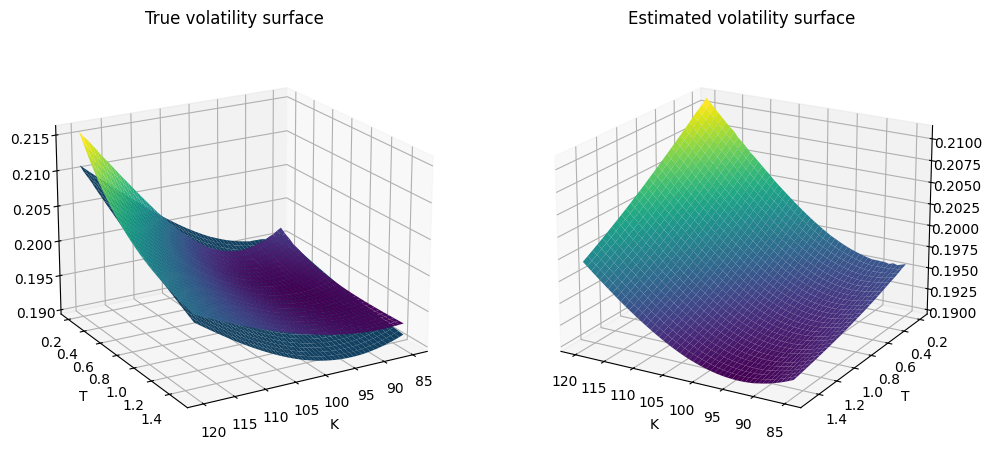

In [ ]:
T, K = np.meshgrid(maturities, strikes)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection = '3d')
ax.plot_surface(K, T,  imp_vol_surf, cmap='viridis')
ax.plot_surface(K, T,  est_vols)
ax.set_xlabel('K')
ax.set_ylabel('T')
ax.view_init(elev=20, azim=60)
ax.set_title('True volatility surface')

ax1 = fig.add_subplot(122, projection = '3d')
ax1.plot_surface(K, T,  est_vols, cmap='viridis')
ax1.set_xlabel('K')
ax1.set_ylabel('T')
ax1.view_init(elev=20, azim=120)
ax1.set_title("Estimated volatility surface")

plt.show()

--------------------------
Example 3

In [ ]:

r = 0.03 # interest rate
S_0 = 100.0 # initial price
theta = 0.1 # long term volatility
kappa = 1 # mean reversion speed of volatility
eta = 0.4 # vol of vol (instantaneous volatility of the volatility)
sigma_0 = 0.2 # initial volatility v_0 = sigma_0^2
rho = -0.3 # correlation coefficient

params = {"S_0": S_0, "r": r, "sigma_0": sigma_0,
          "eta": eta, "kappa":kappa, "theta": theta, "rho":rho}

strikes = np.linspace(85, 120, 50)
maturities = np.linspace(0.2, 1.5, 28) # in years


model_prices_Fou = price_Fourier_wrapper(strikes, maturities,params=params, N=N, h=h)

imp_vol_surf = implied_vol_Surf(strikes, maturities, S_0, r, model_prices_Fou, solver_method="optimizer")

market_vols_surf = imp_vol_surf + 0.001 * np.random.normal(loc = 0, scale = 1, size = imp_vol_surf.shape)


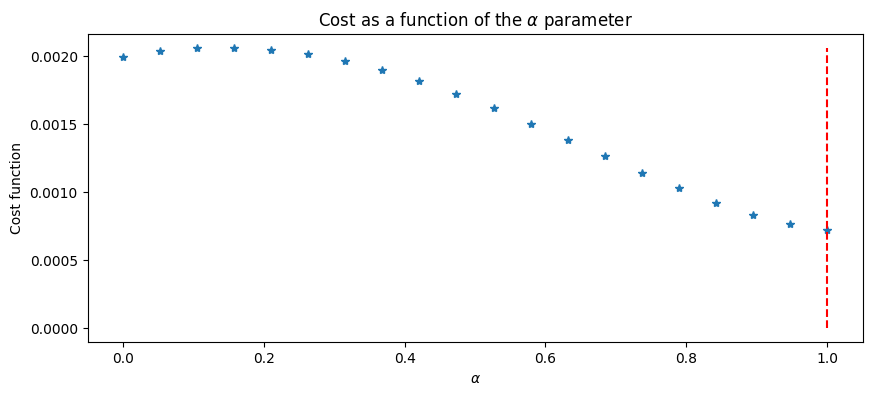

In [ ]:
bounds = [(1e-5, None), (1e-5, None), (1e-5,None), (-1,1)]
Theta13 = [np.abs(np.random.randn()), np.random.uniform(), np.random.uniform(), np.random.uniform(low=-1, high=1)]
Theta23 = [np.abs(np.random.randn()), np.random.uniform(), np.random.uniform(), np.random.uniform(low=-1, high=1)]

optimal_initial_guess, cost = optimal_initialization(Theta13, Theta23,
                            volatilitySurf_error_function, strikes, maturities, params, market_vols_surf)


In [ ]:
print(f"true parameters are: {[kappa, theta, eta, rho]}")
print("----------------------------- \n ----------------------------- \n")

print(f"initial guess = {optimal_initial_guess} \n")
print("----------------------------- \n ----------------------------- \n")

estimated_params_volsurf_Fou = calibration(volatilitySurf_error_function, optimal_initial_guess, (strikes, maturities,params, market_vols_surf, 'Fourier', 'optimizer'), bounds, method = None)

print(f"the estimated_params from volatilities using Fourier as pricing_method are \n {estimated_params_volsurf_Fou}")





true parameters are: [1, 0.1, 0.4, -0.3]
----------------------------- 
 ----------------------------- 

initial guess = [0.35570544 0.25262626 0.56445098 0.65633361] 

----------------------------- 
 ----------------------------- 

The value of the objective is : 2.179072963931443e-06
the estimated_params from volatilities using Fourier as pricing_method are 
 {'kappa': np.float64(0.24), 'theta': np.float64(0.24), 'eta': np.float64(0.34), 'rho': np.float64(-0.29)}


In [ ]:
est_params = params.copy()
est_params.update(estimated_params_volsurf_Fou)

est_prices = price_Fourier_wrapper(strikes, maturities, est_params)
est_vols = implied_vol_Surf(strikes, maturities, S_0, r, est_prices)




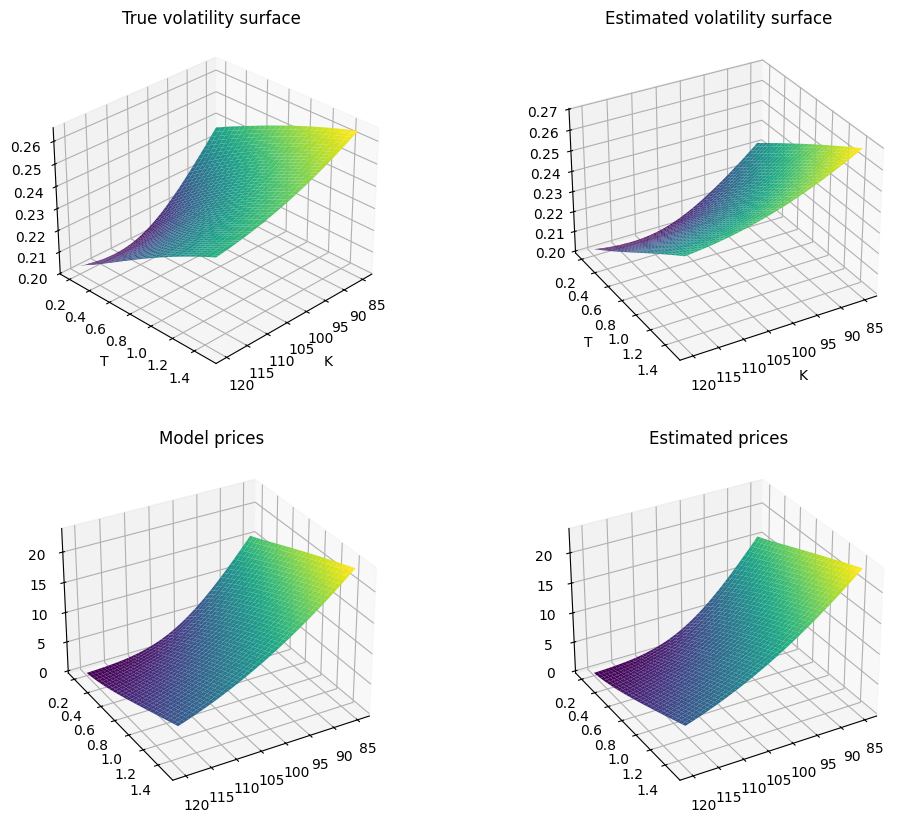

In [ ]:
T, K = np.meshgrid(maturities, strikes)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(221, projection = '3d')
ax.plot_surface(K, T,  imp_vol_surf, cmap='viridis')
# ax.plot_surface(K, T,  est_vols)
ax.set_xlabel('K')
ax.set_ylabel('T')
ax.view_init(elev=30, azim=45)
ax.set_title('True volatility surface')

ax1 = fig.add_subplot(222, projection = '3d')
ax1.plot_surface(K, T,  est_vols, cmap='viridis')
ax1.set_xlabel('K')
ax1.set_ylabel('T')
ax1.view_init(elev=30, azim=60)
ax1.set_title("Estimated volatility surface")

ax3 = fig.add_subplot(223, projection = '3d')
ax3.plot_surface(K, T,  model_prices_Fou, cmap='viridis')
ax3.view_init(elev=30, azim=60)
ax3.set_title("Model prices")


ax4 = fig.add_subplot(224, projection = '3d')
ax4.plot_surface(K, T,  est_prices, cmap='viridis')
ax4.view_init(elev=30, azim=60)
ax4.set_title("Estimated prices")


plt.show()